In [1]:
!module load tensorflow
!hostname
#Based on: https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/
#and https://github.com/nachi-hebbar/Transfer-Learning-ResNet-Keras/blob/main/ResNet_50.ipynb
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

openblas/system loaded
fftw/system loaded
flatbuffers/2.0.0 loaded
flatbuffers-python/2.0 loaded
hwloc/2.2.0 loaded
h5py/3.1.0 loaded
cuda/system loaded
nccl/2.8.4-cuda-system loaded
tensorflow/2.5.0-cuda-system loaded
c208-2


2023-11-04 05:49:33.365879: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 05:49:33.407459: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 05:49:33.407488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 05:49:33.407518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-04 05:49:33.415279: I tensorflow/core/platform/cpu_feature_g

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
img_height,img_width=180,180
batch_size=32

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
tf.config.set_visible_devices(physical_devices[0:1],'GPU') 
strategy = tf.distribute.MultiWorkerMirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO


2023-11-04 05:49:37.372008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38375 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:17:00.0, compute capability: 8.0


In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size*2) #Double the batch size for 2 GPUs

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size*2) #double the batch size for 2 GPUs


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


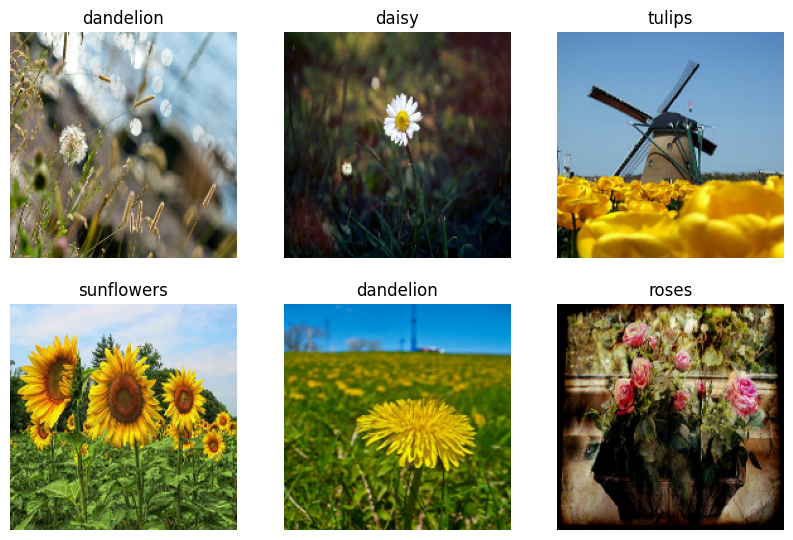

In [5]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#BATCH_SIZE_PER_REPLICA = 32
#GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
#train_batches = train_ds.batch(GLOBAL_BATCH_SIZE)
#val_batches = val_ds.batch(GLOBAL_BATCH_SIZE)

with strategy.scope():   
    resnet_model = Sequential()
    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
    for layer in pretrained_model.layers:
        layer.trainable=False
    resnet_model.add(pretrained_model)
    resnet_model.add(Flatten())
    resnet_model.add(Dense(512, activation='relu'))
    resnet_model.add(Dense(5, activation='softmax'))
    resnet_model.summary()    
    resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#history = resnet_model.fit(train_batches, validation_data=val_batches, epochs=10)
history = resnet_model.fit(train_ds,validation_data=val_ds, epochs=10)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24639365 (93.99 MB)
Trainable params: 1051653 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/10


2023-11-04 05:49:45.858971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-04 05:49:46.720722: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5583f355e870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-04 05:49:46.720754: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-11-04 05:49:46.725663: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-04 05:49:46.841948: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 [==============================] - 8s 81ms/step - loss: 1.0734 - accuracy: 0.7149 - val_loss: 0.3912 - val_accuracy: 0.8515
Epoch 2/10
45/46 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8861

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()